In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import numpy
#from fastkml import kml
from bs4 import BeautifulSoup
from PIL import Image
import matplotlib.image as mpimg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
#Im going to create a function. The input of the function is a raster file with dimentions (n pixels,m pixels), 
#and the output is going to be an array of dimmensions (m*n,1). That means, that each pixel is going to have a unique identifier 
#(index in the array). This index follows the formula (i*n)+j where (i,j) is the position of the pixel in the image and n is the 
#width of the image.

def feature_to_array(file_n):
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    feature=[i for a in imarray for i in a]
    return feature

In [4]:
file_name='Raster_images/BusStop.png'
im = mpimg.imread(file_name)  
im_greyscale = rgb2gray(im)  

In [5]:
file_name='Raster_images/BusStop.png'
array1=feature_to_array(file_name)
len(array1)

935000

In [6]:
#LABEL
file_name='Raster_images/Case.png'
array2=feature_to_array(file_name)
len(array2)

935000

In [7]:
#IN OR OUT SINGAPOURE
file_name='Raster_images/Land.png'
array3=feature_to_array(file_name)
len(array3)

935000

In [8]:
file_name='Raster_images/Mosquito.png'
array4=feature_to_array(file_name)
len(array4)

935000

In [9]:
file_name='Raster_images/Str_Density.png'
array5=feature_to_array(file_name)
len(array5)

935000

In [10]:
file_name='Raster_images/Trash.png'
array6=feature_to_array(file_name)
len(array6)

935000

In [11]:
array22=list(array2/np.max(array2))
inorout33=list(1-(array3/np.max(array3)))

In [12]:
Data=pd.DataFrame([array1,array22,array4,array5,array6]).T

In [13]:
Data.head()

,0,1,2,3,4
0,0.941176,1,0.941176,0.941176,0.941176
1,0.941176,1,0.941176,0.941176,0.941176
2,0.941176,1,0.941176,0.941176,0.941176
3,0.941176,1,0.941176,0.941176,0.941176
4,0.941176,1,0.941176,0.941176,0.941176


In [14]:
Data_filt=Data[np.array(inorout33)==1.0]

In [15]:
Data_filt.head()

,0,1,2,3,4
147867,0.941176,1,0.941176,0.941176,0.941176
150112,0.941176,1,0.941176,0.941176,0.941176
150113,0.941176,1,0.941176,0.941176,0.941176
150114,0.941176,1,0.941176,0.941176,0.941176
151167,0.219608,1,0.941176,0.121569,0.000000


In [16]:
#Outuput: dictionary linking index of one dimmensional array and original i,j position of pixel:
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)/int(n), 'j':M-((int(M)/int(n))*n)}
    return index_2dim

In [17]:
original_index_dict=indexes(m,n)

In [18]:
original_index_dict[386]

{'i': 0, 'j': 386L}

###MACHINE LEARNING PART

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
import itertools

In [20]:
pca = PCA()
forest = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])

In [21]:
X = Data_filt[[0,2,3,4]]
Y = Data_filt[1]

In [22]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)

In [23]:
pca.fit(X_train.as_matrix())

PCA(copy=True, n_components=None, whiten=False)

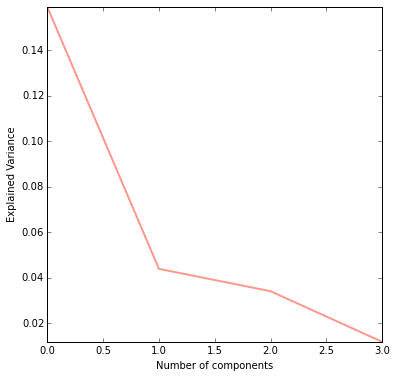

In [24]:
plt.figure(1, figsize=(6, 6))
plt.plot(pca.explained_variance_, linewidth=2, c='salmon', alpha=0.8)
plt.axis('tight')
plt.xlabel('Number of components');
plt.ylabel('Explained Variance');

In [25]:
def get_results(n_components,max_features,criterion,n_estimators,X,Y):
    from sklearn.metrics import accuracy_score
    from sklearn.cross_validation import KFold
    from sklearn.ensemble import RandomForestClassifier
    kf = KFold(n=len(X), n_folds=12, shuffle=True, random_state=21)
    d = []
    for train_index, test_index in kf:
        for rf_features,criter,rf_estimators in itertools.product(max_features,criterion,n_estimators):
            X_tr, X_test = X[train_index], X[test_index]
            X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
            Y_tr, Y_test = Y[train_index], Y[test_index]
            Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
            del X_tr
            del Y_tr
            forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=criter,
                    max_depth=None, max_features=rf_features, max_leaf_nodes=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=rf_estimators, n_jobs=1,
                    oob_score=False, random_state=21, verbose=0,
                    warm_start=False)
            forest.fit(X_train,Y_train)
            forest_pred = forest.predict(X_validation)
            name = '%s,%s,%s'%(str(rf_features),str(criter),str(rf_estimators))
            d.append((name,accuracy_score(Y_validation,forest_pred),X_train,X_test,Y_train,Y_test))
            #forest_probs = forest.predict_proba(X_test)
            #sig_clf = CalibratedClassifierCV(forest, method="sigmoid", cv="prefit")
            #sig_clf.fit(X_validation, Y_validation)
            #sig_clf_probs = sig_clf.predict_proba(X_test)
            #sig_score = log_loss(Y_test, sig_clf_probs)
    return sorted(d, key=lambda tup: tup[1])[-1]

In [26]:
n_components = [1,2,3,4]#,5,6,7]
max_features = ['auto','sqrt','log2']
criterion = ['gini','entropy']
n_estimators = [3,6,9]

In [27]:
best = get_results(n_components,max_features,criterion,n_estimators,X.as_matrix(),Y.as_matrix())
best_params,X_train_best,X_test_best,Y_train_best,Y_test_best = best[0].split(','),best[2],best[3],best[4],best[5]
print X_train_best.shape
print Y_train_best.shape
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=best_params[1],
                max_depth=None, max_features=best_params[0], max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=int(best_params[2]), n_jobs=1,
                oob_score=False, random_state=21, verbose=0,
                warm_start=False)
forest.fit(X_train_best,Y_train_best)
print accuracy_score(Y_test_best,forest.predict(X_test_best))

(205016L, 4L)
(205016L,)
0.990642572005


In [28]:
pred_labels=forest.predict(X)

In [29]:
sum([pred_labels==0])

2951

In [30]:
Data_filt['pred_labels']=pred_labels

C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [31]:
Data_filt.head()

,0,1,2,3,4,pred_labels
147867,0.941176,1,0.941176,0.941176,0.941176,1
150112,0.941176,1,0.941176,0.941176,0.941176,1
150113,0.941176,1,0.941176,0.941176,0.941176,1
150114,0.941176,1,0.941176,0.941176,0.941176,1
151167,0.219608,1,0.941176,0.121569,0.000000,1


In [32]:
#0 disease, 1 no disease, 2 outside singapore 


C:\Users\Marco\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


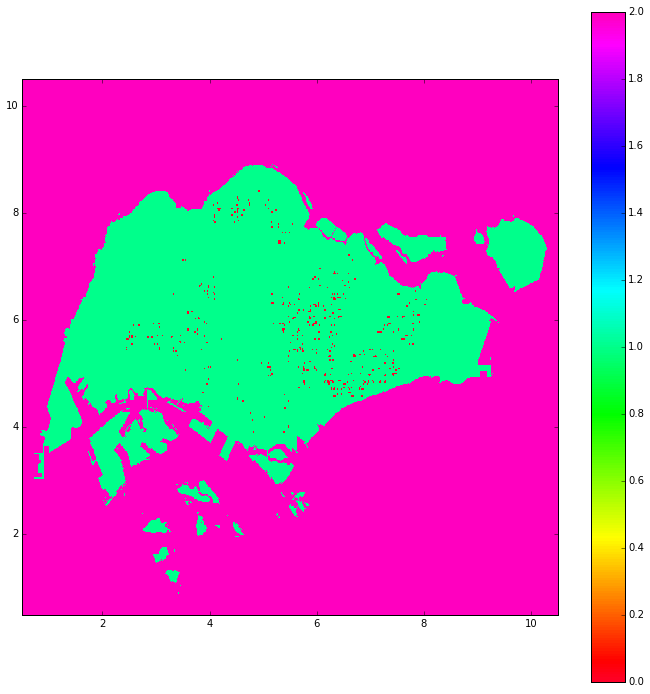

In [33]:
matrix = np.zeros((m,n))+2
for M in Data_filt.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=Data_filt.pred_labels[M]
m_l=matrix.tolist()
fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_l, interpolation='nearest', cmap='gist_rainbow', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.show()

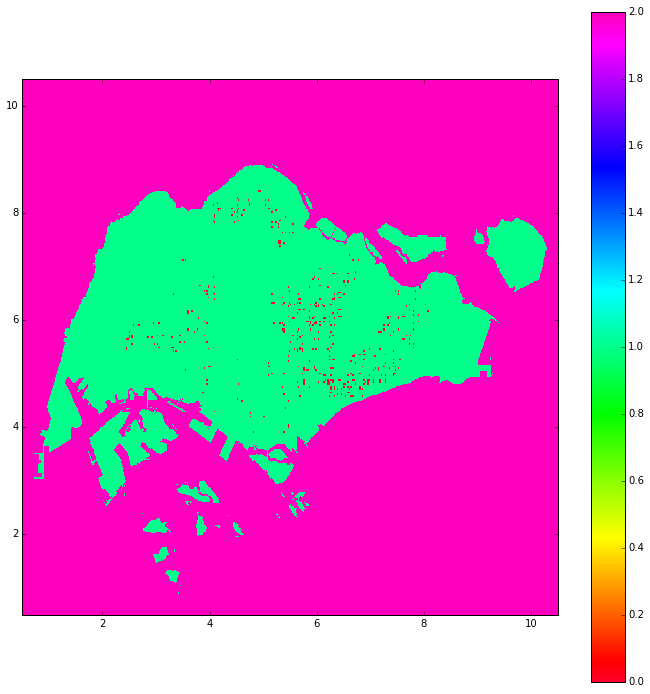

In [34]:
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
matrix_real=np.zeros((m,n))+2
for M in Data_filt.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix_real[i][j]=Data_filt[1][M]
m_real=matrix_real.tolist()
fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_real, interpolation='nearest', cmap='gist_rainbow', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.show()

###AUC Score

The AUC, which is part of performance metric of a logistic regression, is a commonly used evaluation metric for binary classification problems like predicting a Buy or Sell decision (binary decision). The interpretation is that given a random positive observation and negative observation, the AUC gives the proportion of the time you guess which is correct. It is less affected by sample balance than accuracy. A perfect model will score an AUC of 1, while random guessing will score an AUC of around 0.5, a meager 50% chance on each other. ( https://www.kaggle.com/wiki/AreaUnderCurve )

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [36]:
rf_predictions=forest.predict_proba(X_test_best)[:, 1]
print roc_auc_score(Y_test_best, rf_predictions)

0.941284649039


Confussion Matrix http://i.stack.imgur.com/lQ12T.png

In [37]:
confusion_matrix(Y, pred_labels)

array([[  2274,   1154],
       [   677, 275463]])

THE CONFUSSION MATRIX doesn't look that bad

###LOGISTIC REGRESSION